# Obtention du DataFrame

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [2]:
def plotRegression(real,predicted):
    fig, ax = plt.subplots()
    ax.scatter(real, predicted, edgecolors=(0, 0, 0))
    ax.plot([real.min(), real.max()], [real.min(), real.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    

In [3]:
def calculateZSCORE(df):
    res = df.copy()
    for name in res.select_dtypes(include=[np.number]).columns:
        col_zscore = name + '_zscore'
        std = res[name].std()
        mean = res[name].mean()
        res[col_zscore] = (res[name] - mean)/ std
    
    return res

def findOutlier(df,threshold=3):
    df = calculateZSCORE(df)
    res = pd.DataFrame(columns=df.columns)
    for name in df.columns:
        if  '_zscore' in name :
            res=res.append(df.loc[(df[name]>threshold)])
            res=res.append(df.loc[(df[name]<-threshold)])
    return res

def replaceOutlier(dfsource,dfListIndex,column,value):
    df = dfsource.copy()
    df.loc[dfListIndex.index,column]=value     
    return df

def replaceListOutliers(dfsource,dfcible,column):
    df = dfsource.copy()
    for i,row in dfcible.iterrows():
        #print(row)
        #print(i)
        df.loc[i,column]=row[column]     
    return df

In [5]:
def dataframe(df):
    df.pop('Unnamed: 21')
    dfDA=df[df.carrier=="AA"]
    dfAL=df[df.carrier=="DL"]
    vol=pd.concat([dfDA,dfAL])
    vol.pop('carrier_name')
    vol.pop('airport_name')
    
    voldum=pd.get_dummies(vol.carrier)
    volnum=pd.concat([voldum,vol],axis=1)
    volnum.pop('carrier')
    
    
    volnan=volnum.dropna()
    volnan['carrier_ct']=volnan['carrier_ct'].apply(lambda x: float(str(x).replace(',','.')))
    volnan['late_aircraft_ct']=volnan['late_aircraft_ct'].apply(lambda x: float(str(x).replace(',','.')))
    volnan['nas_ct']=volnan['nas_ct'].apply(lambda x: float(str(x).replace(',','.')))
    
    return volnan
    

In [9]:
def pourcentage(volnan):
    
    volnan['retards'] = volnan.apply(lambda _: '', axis=1) 
    volnan['retards']=(volnan['arr_del15']/volnan['arr_flights'])*100

    retardvol=volnan.drop('arr_cancelled',axis=1)
    retardvol=retardvol.drop('arr_diverted',axis=1)
    retardvol=retardvol.drop(' arr_delay',axis=1)
    retardvol=retardvol.drop(' carrier_delay',axis=1)
    retardvol=retardvol.drop('weather_delay',axis=1)
    retardvol=retardvol.drop('nas_delay',axis=1)
    retardvol=retardvol.drop('security_delay',axis=1)
    retardvol=retardvol.drop('late_aircraft_delay',axis=1)

    #On convertit les valeurs en % pour plus de cohérence
    retardvol['Rcarrier_ct'] = retardvol.apply(lambda _: '', axis=1) 
    retardvol['Rcarrier_ct']=(volnan['carrier_ct']/volnan['arr_del15'])*100
    retardvol['Rweather_ct'] = retardvol.apply(lambda _: '', axis=1) 
    retardvol['Rweather_ct']=(volnan[' weather_ct']/volnan['arr_del15'])*100
    retardvol['Rnas_ct'] = retardvol.apply(lambda _: '', axis=1) 
    retardvol['Rnas_ct']=(volnan['nas_ct']/volnan['arr_del15'])*100
    retardvol['Rsecurity_ct'] = retardvol.apply(lambda _: '', axis=1) 
    retardvol['Rsecurity_ct']=(volnan['security_ct']/volnan['arr_del15'])*100
    retardvol['Rlate_aircraft_ct'] = retardvol.apply(lambda _: '', axis=1) 
    retardvol['Rlate_aircraft_ct']=(volnan['late_aircraft_ct']/volnan['arr_del15'])*100

    retardvol=retardvol.drop('arr_flights',axis=1)
    retardvol=retardvol.drop('arr_del15',axis=1)
    retardvol=retardvol.drop('carrier_ct',axis=1)
    retardvol=retardvol.drop(' weather_ct',axis=1)
    retardvol=retardvol.drop('nas_ct',axis=1)
    retardvol=retardvol.drop('security_ct',axis=1)
    retardvol=retardvol.drop('late_aircraft_ct',axis=1)
    
    return retardvol

In [61]:
def retard_moy(retardvol):
    retardvol_2=retardvol.copy()
    retardvol_2.reset_index(drop=True)
    retardvol_2['Airport'] = volnan.apply(lambda _: '', axis=1) 
    
    nomair=retardvol_2['airport'].unique()
    moy=pd.DataFrame(nomair,columns=['airports'])
    moy['moyretards'] = moy.apply(lambda _: '', axis=1) 
    for i in range(30):
        moy.moyretards[i]=np.mean(retardvol_2.retards[retardvol_2.airport == moy.airports[i]])
    
    moy['moyretards']=moy['moyretards'].apply(lambda x: float(str(x).replace(',','.')))
    moy.set_index('airports',inplace=True)

    from sklearn import preprocessing
    moy['classement']=moy.apply(preprocessing.LabelEncoder().fit_transform)
    
    
    for j in nomair: 
        retardvol_2.Airport[retardvol_2.airport==j]=moy.classement[j]
    retardvol_2['Airport']=retardvol_2['Airport'].apply(lambda x: int(str(x).replace(',','.')))
    
    retardvol_2=retardvol_2.drop('airport',axis=1)
    
    return retardvol_2,moy

In [92]:
def manage_cluster(X,n):
    from sklearn.cluster import KMeans
    
    P=X.copy()

    
    y_pred = KMeans(n_clusters=n, random_state=42).fit_predict(P)

    return y_pred


## Parseurs

In [28]:
def parse_quick(df):
    dh=df.copy()
    y=dh.pop('retards')
    x=dh.drop('airport',axis=1)
    return x,y

In [37]:
def parse_moy(df):
    dh=df.copy()
    y=dh.pop('retards')
    
    return dh,y
    

## Code

In [8]:
df = pd.read_csv('airline-delay-causes.csv',sep=";", decimal=".",engine='python')
volnan=dataframe(df)
volnan.head()

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,AA,DL,year,month,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
15,1,0,2016,7,DEN,998.0,368.0,115.63,13.75,114.45,0.52,123.65,12.0,3.0,22760.0,7514.0,1451.0,4764.0,25.0,9006.0
16,1,0,2017,6,TPA,998.0,266.0,61.03,12.20,98.50,0.63,93.64,11.0,2.0,16574.0,4434.0,986.0,4448.0,10.0,6696.0
18,1,0,2004,1,SFO,997.0,309.0,60.98,35.04,160.89,2.80,49.27,35.0,1.0,15284.0,3777.0,1908.0,6307.0,116.0,3176.0
22,1,0,2007,9,JFK,997.0,338.0,85.66,3.76,195.47,0.80,52.31,11.0,4.0,18785.0,6531.0,405.0,8296.0,66.0,3487.0
24,1,0,2008,9,BOS,997.0,210.0,60.94,5.22,95.74,0.00,48.11,9.0,3.0,10188.0,2932.0,335.0,3851.0,0.0,3070.0


# Analyse des données

##### Pourcentage de retards plus parlant que le nombre de retards car aéroports de tailles différentes


##### On essaye de regrouper les "familles de variables" et on modifie les valeurs pour qu'elles soient pertinentes entre elles 

In [12]:
train=pourcentage(volnan)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 15 to 58996
Data columns (total 11 columns):
AA                   9963 non-null uint8
DL                   9963 non-null uint8
year                 9963 non-null int64
 month               9963 non-null int64
airport              9963 non-null object
retards              9963 non-null float64
Rcarrier_ct          9963 non-null float64
Rweather_ct          9963 non-null float64
Rnas_ct              9963 non-null float64
Rsecurity_ct         9963 non-null float64
Rlate_aircraft_ct    9963 non-null float64
dtypes: float64(6), int64(2), object(1), uint8(2)
memory usage: 797.8+ KB


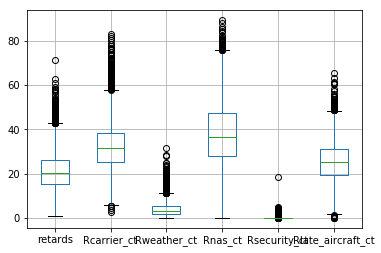

In [11]:
moust=train.drop('AA',axis=1)
moust=moust.drop('DL',axis=1)
moust=moust.drop('year',axis=1)
moust=moust.drop(' month',axis=1)
moust=moust.drop('airport',axis=1)
moust.boxplot()

<Figure size 1440x1152 with 0 Axes>

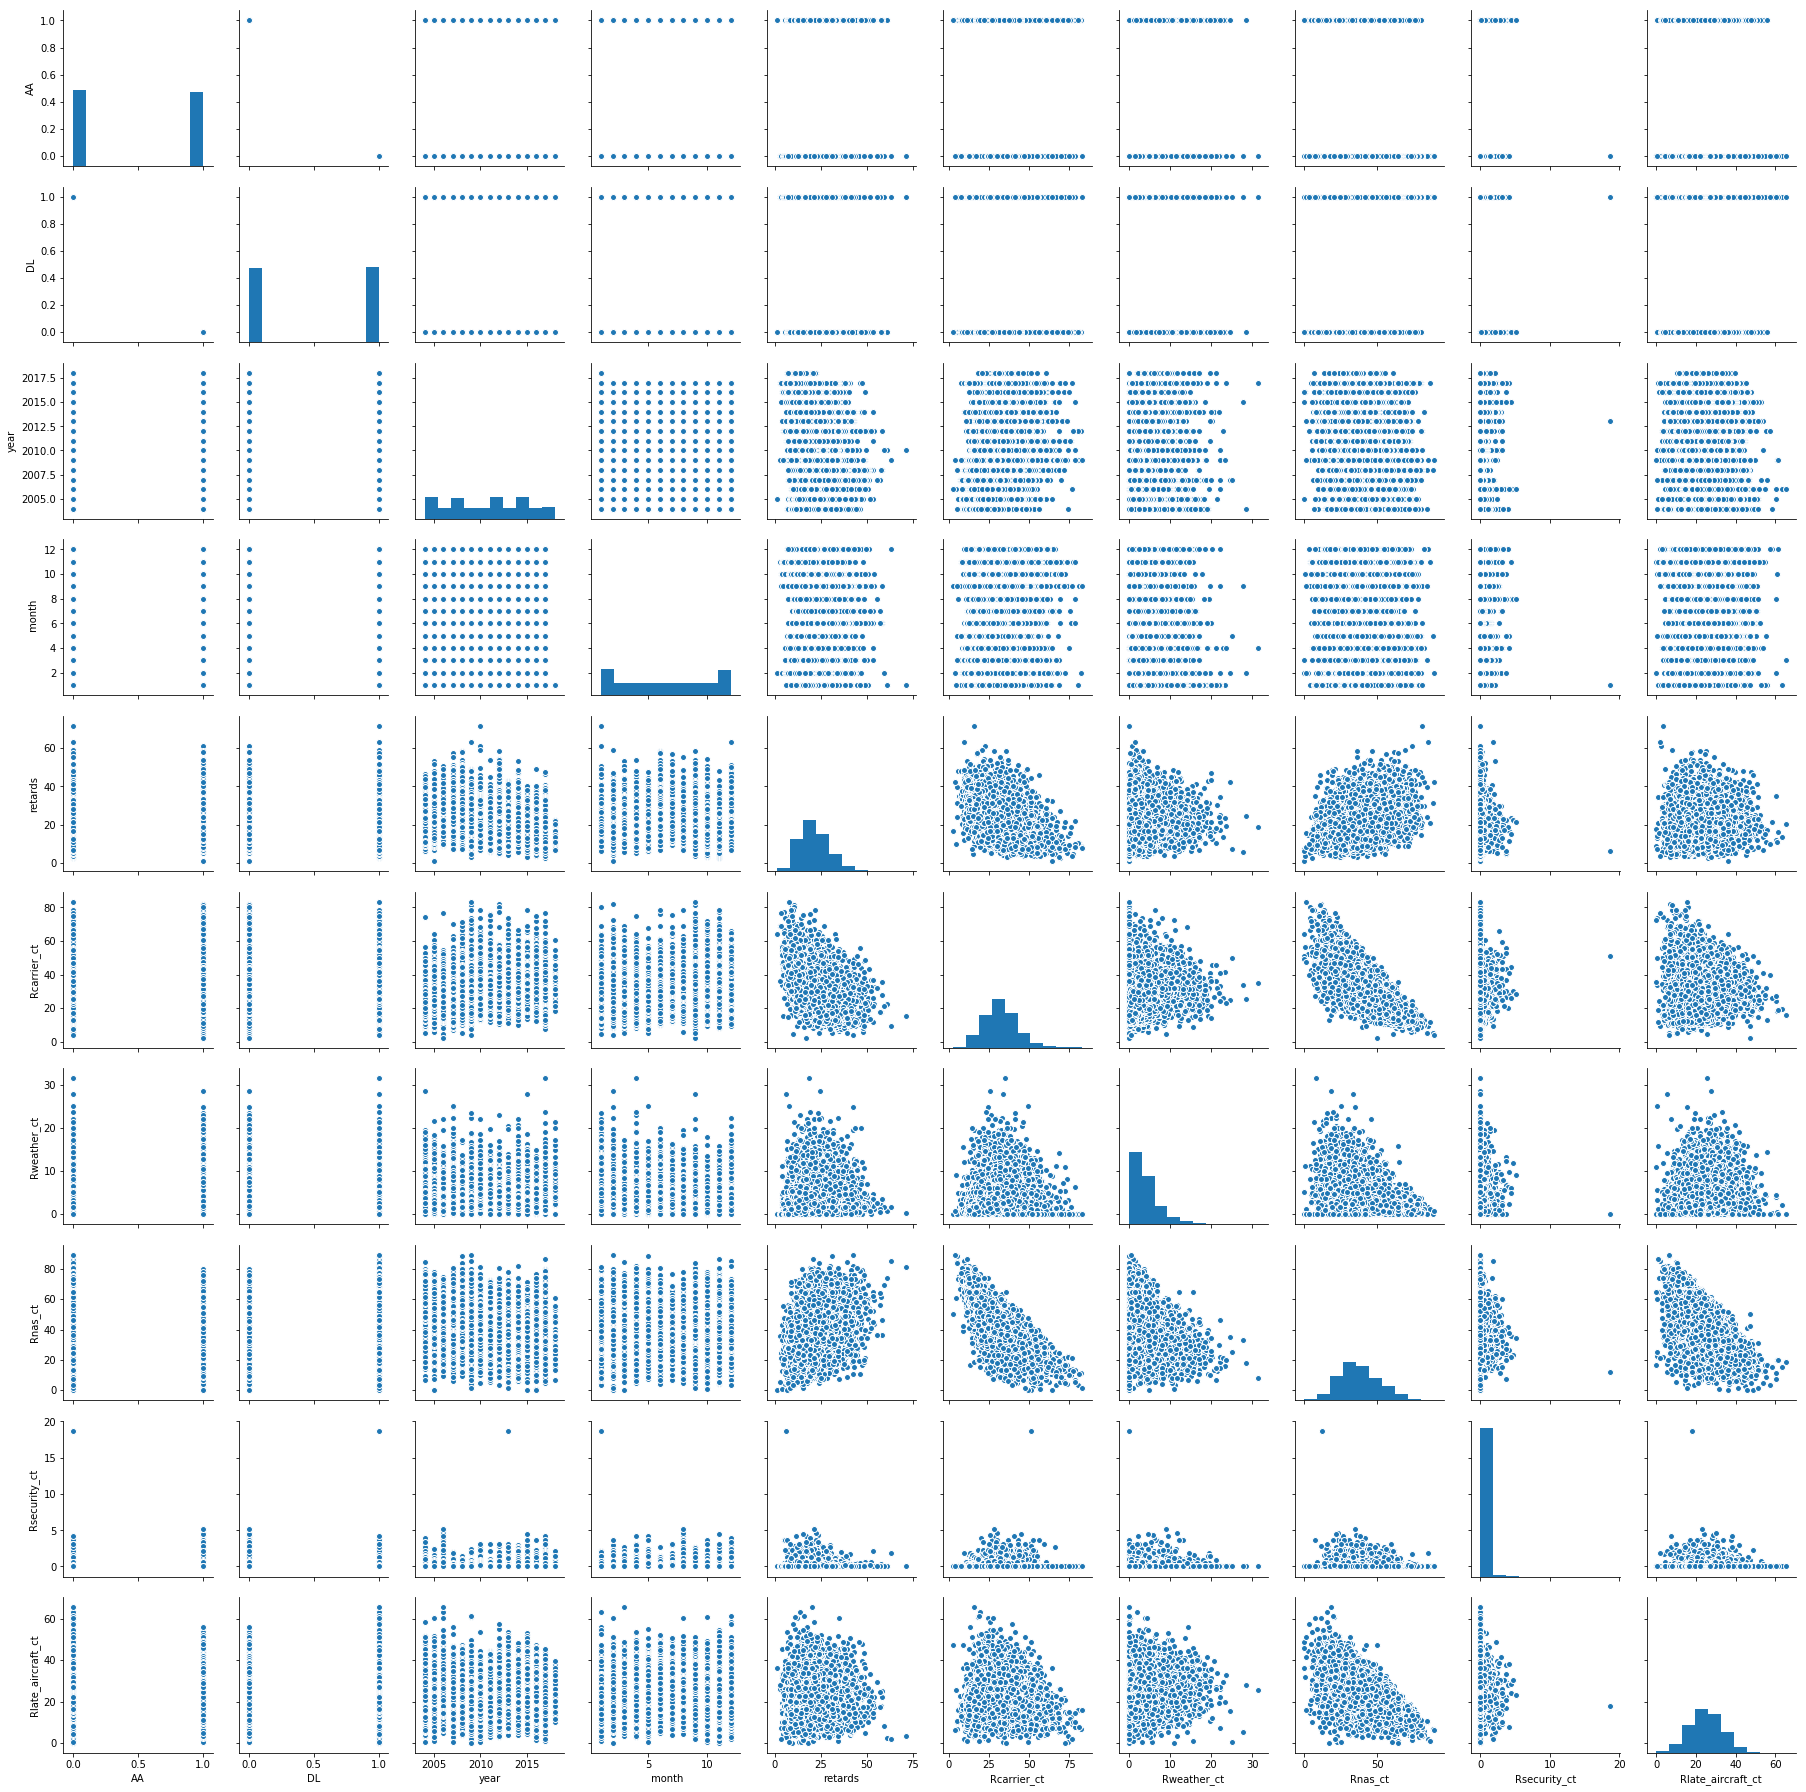

In [13]:
plt.figure(figsize=(20, 16))

sns.pairplot(retardvol)

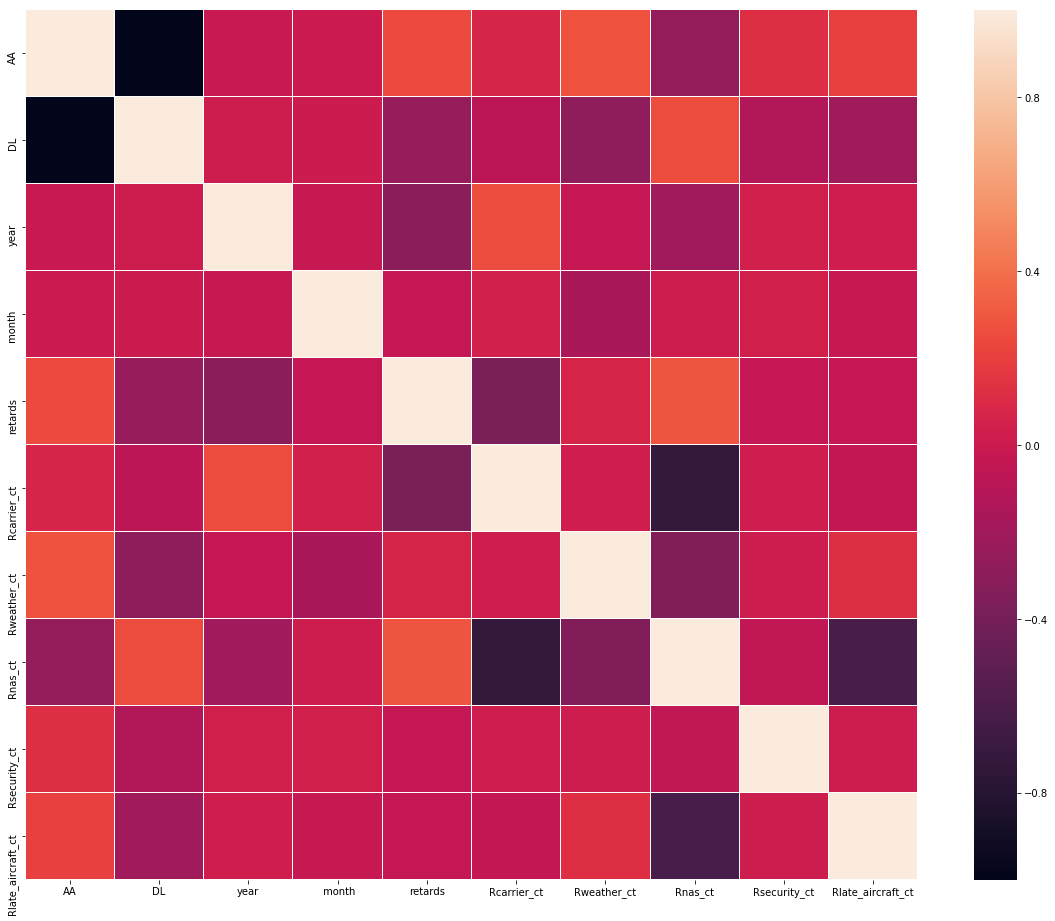

In [14]:
plt.figure(figsize=(20, 16))
sns.heatmap(retardvol.corr(),linewidths=.1) 

# Test de regression Quick and dirty

prediction based on test set


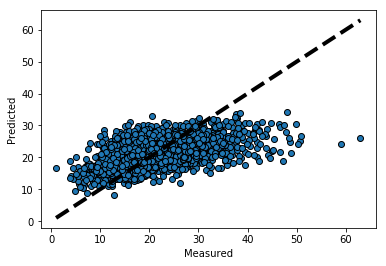

R^2: 0.2793865866880987
Root Mean Squared Error: 6.918967081685052


In [26]:
Xquick,Yquick=parse_quick(train)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xquick, Yquick, test_size=0.20, random_state=42)
lm=LinearRegression()
lm.fit(X_train,y_train)
predictions=lm.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(lm.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))

#### Essais Random Forest

prediction based on test set


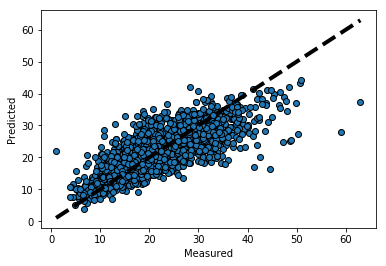

R^2: 0.5722745002407947
Root Mean Squared Error: 5.330557896870128


In [27]:
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
pred=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,pred)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,pred))
print("Root Mean Squared Error: {}".format(rmse))

## Ajout de la feature "airport"

On classe les aéroport par moyenne de retard (odre croissant)

In [62]:
newtrain,moy=retard_moy(train)
newtrain.head()

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rsecurity_ct,Rlate_aircraft_ct,Airport
15,1,0,2016,7,36.873747,31.421196,3.736413,31.100543,0.141304,33.600543,18
16,1,0,2017,6,26.653307,22.943609,4.586466,37.030075,0.236842,35.203008,6
18,1,0,2004,1,30.992979,19.734628,11.339806,52.067961,0.906149,15.944984,28
22,1,0,2007,9,33.901705,25.343195,1.112426,57.831361,0.236686,15.476331,26
24,1,0,2008,9,21.063190,29.019048,2.485714,45.590476,0.000000,22.909524,19


In [32]:
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 15 to 58996
Data columns (total 11 columns):
AA                   9963 non-null uint8
DL                   9963 non-null uint8
year                 9963 non-null int64
 month               9963 non-null int64
retards              9963 non-null float64
Rcarrier_ct          9963 non-null float64
Rweather_ct          9963 non-null float64
Rnas_ct              9963 non-null float64
Rsecurity_ct         9963 non-null float64
Rlate_aircraft_ct    9963 non-null float64
Airport              9963 non-null int64
dtypes: float64(6), int64(3), uint8(2)
memory usage: 797.8 KB


Nouveau test

prediction based on test set


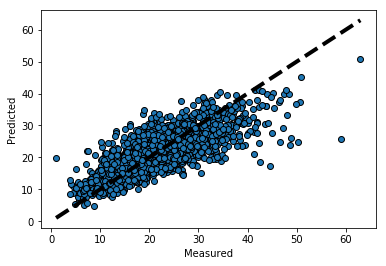

R^2: 0.604037309426946
Root Mean Squared Error: 5.128817276782709


In [38]:
x_data,y_val=parse_moy(newtrain)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_val, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictions=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))


# Test Nettoyage

In [55]:
netvol=newtrain.copy()

In [42]:
netvol.describe()

,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rsecurity_ct,Rlate_aircraft_ct,Airport
count,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000
mean,0.495032,0.504968,2010.539396,6.465623,21.290066,32.159794,4.117810,38.273033,0.114829,25.334496,14.750577
std,0.500000,0.500000,4.068542,3.466636,8.211482,10.312099,3.436406,13.858410,0.395378,8.476835,8.514388
min,0.000000,0.000000,2004.000000,1.000000,1.020408,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2007.000000,3.000000,15.308903,25.171573,1.713828,28.207825,0.000000,19.441332,7.000000
50%,0.000000,1.000000,2011.000000,6.000000,20.329670,31.523810,3.306818,36.637450,0.000000,25.142857,15.000000
75%,1.000000,1.000000,2014.000000,9.000000,26.269922,38.309691,5.565757,47.283653,0.000000,31.099336,22.000000
max,1.000000,1.000000,2018.000000,12.000000,71.428571,83.166667,31.500000,89.282258,18.666667,65.527778,29.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05092dcef0>,
      dtype=object)

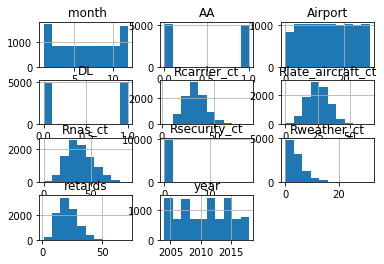

In [43]:
netvol.hist()

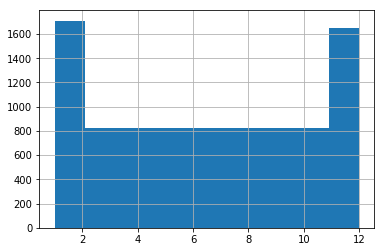

In [44]:
netvol[' month'].hist() #chelou

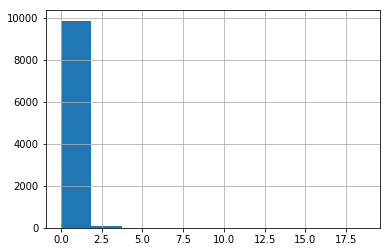

In [45]:
netvol['Rsecurity_ct'].hist() #envie de la supprimée 

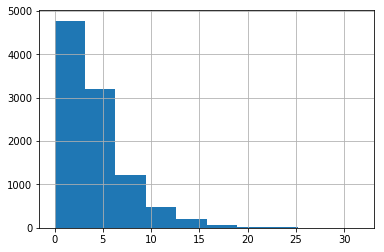

In [46]:
netvol['Rweather_ct'].hist() #on applique un log  pour normaliser? 

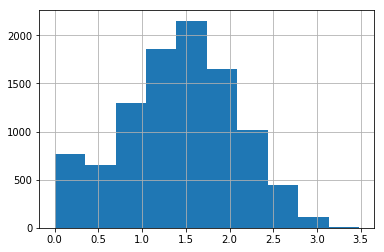

In [47]:
np.log(netvol['Rweather_ct']+1).hist()

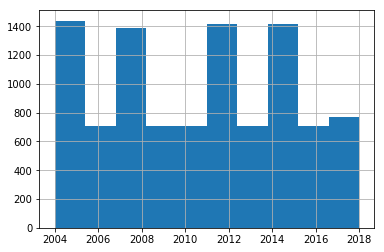

In [48]:
netvol['year'].hist()

In [53]:
netvol['Rweather_ct']=np.log(netvol['Rweather_ct']+1)

In [56]:
netvol=netvol.drop('Rsecurity_ct',axis=1) #on essaye de virer cette feature 

prediction based on test set


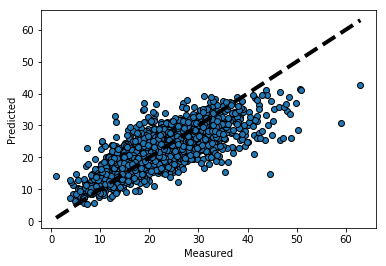

R^2: 0.594112672723384
Root Mean Squared Error: 5.1926952987116515


In [57]:
x_datanet,y_valnet=parse_moy(netvol)
X_train, X_test, y_train, y_test = train_test_split(x_datanet, y_valnet, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictions=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))


#### C'est un poil mieux 

On détecte les outliers ?  
On réindex

In [96]:
netvol_2=netvol.reset_index(drop=True)
netvol_2['airport']=netvol_2.apply(lambda _: '', axis=1) 

In [97]:
nomair=train['airport'].unique()
for j in nomair:
    netvol_2['airport'][netvol_2.Airport==moy.classement[j]]=j
#On rajoute les noms d'aéroport 

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
netvol_2.head()

,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rlate_aircraft_ct,Airport,airport
0,1,0,2016,7,36.873747,31.421196,3.736413,31.100543,33.600543,18,DEN
1,1,0,2017,6,26.653307,22.943609,4.586466,37.030075,35.203008,6,TPA
2,1,0,2004,1,30.992979,19.734628,11.339806,52.067961,15.944984,28,SFO
3,1,0,2007,9,33.901705,25.343195,1.112426,57.831361,15.476331,26,JFK
4,1,0,2008,9,21.063190,29.019048,2.485714,45.590476,22.909524,19,BOS


In [99]:
netvol_2[netvol_2.retards>55]

,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rlate_aircraft_ct,Airport,airport
3555,1,0,2012,9,58.149780,35.530303,3.318182,36.196970,24.946970,7,BWI
3619,1,0,2010,1,60.829493,22.621212,0.757576,74.166667,2.454545,23,HNL
3718,1,0,2008,6,58.095238,28.008197,3.483607,46.303279,22.204918,22,PDX
4887,1,0,2008,6,57.666345,17.976589,2.102007,61.692308,17.949833,28,SFO
5402,0,1,2009,12,62.962963,9.372549,1.647059,85.176471,1.960784,23,HNL
7978,0,1,2010,1,71.428571,15.600000,0.153846,81.133333,3.112821,23,HNL
8157,0,1,2010,2,59.036145,20.979592,1.700680,69.333333,7.986395,23,HNL
9382,0,1,2007,7,56.894049,17.920918,1.151786,56.278061,24.521684,26,JFK
9481,0,1,2007,6,57.187017,17.924324,0.352703,64.398649,17.324324,26,JFK
9900,0,1,2007,8,55.339806,31.842105,2.614035,36.175439,29.350877,11,MSP


On remarque que l'aéroport 23 (HONOLULU) est celui concerné par les plus gros retards: 

In [100]:
retardmax=netvol_2[netvol_2.retards>55]
retardmax23=retardmax[retardmax.Airport==23]

Gros problèmes de NAS lors de 3 mois consécutifs, donc gros retards. Cependant, aéroport avec une moyenne de retards proche de 20%, donc inhabituel. On remplace les retards par le retard moyen ? ? -> on supprime les features 

In [101]:
netvol_2['retards'][netvol_2.retards>55][netvol_2.Airport==23]

3619    60.829493
5402    62.962963
7978    71.428571
8157    59.036145
Name: retards, dtype: float64

In [102]:
netvol_2=netvol_2.drop(3619,axis=0)
netvol_2=netvol_2.drop(5402,axis=0)
netvol_2=netvol_2.drop(7978,axis=0)
netvol_2=netvol_2.drop(8157,axis=0)
#On supprime ces valeurs

In [103]:
netvol_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9959 entries, 0 to 9962
Data columns (total 11 columns):
AA                   9959 non-null uint8
DL                   9959 non-null uint8
year                 9959 non-null int64
 month               9959 non-null int64
retards              9959 non-null float64
Rcarrier_ct          9959 non-null float64
Rweather_ct          9959 non-null float64
Rnas_ct              9959 non-null float64
Rlate_aircraft_ct    9959 non-null float64
Airport              9959 non-null int64
airport              9959 non-null object
dtypes: float64(5), int64(3), object(1), uint8(2)
memory usage: 797.5+ KB


Il faut donc reclasser les aéroports par retards moyen

In [104]:
newmoy=pd.DataFrame(nomair,columns=['airports'])
newmoy['moyretards'] = moy.apply(lambda _: '', axis=1) 

In [105]:
for i in range(30):
    newmoy.moyretards[i]=np.mean(netvol_2.retards[netvol_2.airport == newmoy.airports[i]])
    
newmoy['moyretards']=newmoy['moyretards'].apply(lambda x: float(str(x).replace(',','.')))
newmoy.set_index('airports',inplace=True)

In [106]:
from sklearn import preprocessing
newmoy['classement']=newmoy.apply(preprocessing.LabelEncoder().fit_transform)
newmoy
#obtention d'un nouveau classement 

,moyretards,classement
airports,,
DEN,21.117218,18
TPA,19.662261,6
SFO,26.626199,28
JFK,23.371330,26
BOS,21.330698,19
MCO,20.657859,13
ATL,20.475064,12
SEA,22.091535,21
MDW,17.179984,0


In [107]:
for j in nomair: 
    netvol_2.Airport[netvol_2.airport==j]=newmoy.classement[j]
netvol_2['Airport']=netvol_2['Airport'].apply(lambda x: float(str(x).replace(',','.')))

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
netvol_2.head()

,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rlate_aircraft_ct,Airport,airport
0,1,0,2016,7,36.873747,31.421196,3.736413,31.100543,33.600543,18.0,DEN
1,1,0,2017,6,26.653307,22.943609,4.586466,37.030075,35.203008,6.0,TPA
2,1,0,2004,1,30.992979,19.734628,11.339806,52.067961,15.944984,28.0,SFO
3,1,0,2007,9,33.901705,25.343195,1.112426,57.831361,15.476331,26.0,JFK
4,1,0,2008,9,21.063190,29.019048,2.485714,45.590476,22.909524,19.0,BOS


prediction based on test set


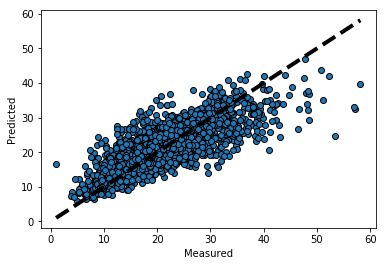

R^2: 0.595174990293055
Root Mean Squared Error: 5.141241652459849


In [109]:
x_datasup,y_valsup=parse_quick(netvol_2)
X_train, X_test, y_train, y_test = train_test_split(x_datasup, y_valsup, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictions=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))

prediction based on test set


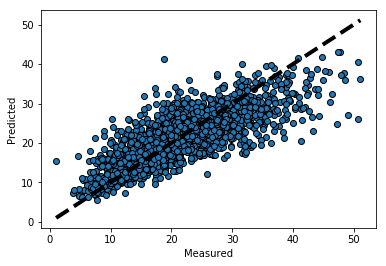

R^2: 0.6024981497700062
Root Mean Squared Error: 5.092297648853798


In [81]:
netvol_3=netvol_2[netvol_2.retards<55]
x_datasup,y_valsup=parse_quick(netvol_3)
X_train, X_test, y_train, y_test = train_test_split(x_datasup, y_valsup, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictions=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))

Pas la bonne solution de supp les retards les plus gros non plus

# TEST CLUSTURING

## But: clusters d'aéroport par retards moyen 

In [113]:
airport=netvol_2.pop('airport')

KeyError: 'airport'

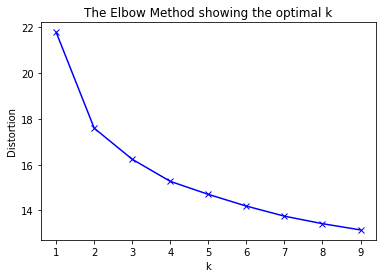

In [114]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
n_row=len(netvol_2['year'])
X = netvol_2

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / n_row)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [115]:
netvol_2['cluster']=manage_cluster(netvol_2,2)

In [122]:
netvol_3=netvol_2.reset_index(drop=True)
netvol_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9959 entries, 0 to 9958
Data columns (total 11 columns):
AA                   9959 non-null uint8
DL                   9959 non-null uint8
year                 9959 non-null int64
 month               9959 non-null int64
retards              9959 non-null float64
Rcarrier_ct          9959 non-null float64
Rweather_ct          9959 non-null float64
Rnas_ct              9959 non-null float64
Rlate_aircraft_ct    9959 non-null float64
Airport              9959 non-null float64
cluster              9959 non-null int32
dtypes: float64(6), int32(1), int64(2), uint8(2)
memory usage: 680.9 KB


prediction based on test set


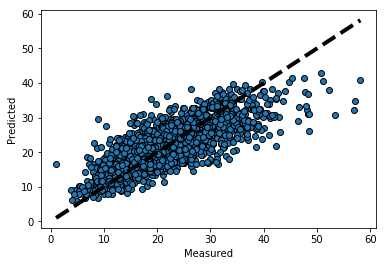

R^2: 0.6150000121469672
Root Mean Squared Error: 5.013773468007995


In [126]:
x_datasup,y_valsup=parse_moy(netvol_3)
X_train, X_test, y_train, y_test = train_test_split(x_datasup, y_valsup, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictions=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictions)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("Root Mean Squared Error: {}".format(rmse))


Amélioration, on passe sous la barre des 5

## But : cluster par type de retards 

In [135]:
df_airport=netvol_3.copy()
df_airport=
moyRcarrier=pd.DataFrame(nomair,columns=['airports'])
moyRcarrier['moyRcarrier_ct'] = moyRcarrier.apply(lambda _: '', axis=1) 
for i in range(30):
    moyRcarrier.moyRcarrier_ct[i]=np.mean(netvol_3.Rcarrier_ct[netvol_3.airport == moyRcarrier.airports[i]])
    
moyRcarrier['moyRcarrier_ct']=moyRcarrier['moyRcarrier_ct'].apply(lambda x: float(str(x).replace(',','.')))
moyRcarrier.set_index('airports',inplace=True)

AttributeError: 'DataFrame' object has no attribute 'airport'

AttributeError: 'DataFrame' object has no attribute 'airports'

In [85]:
moyRcarrier['classement']=moyRcarrier.apply(preprocessing.LabelEncoder().fit_transform)
moyRcarrier

,moyRcarrier_ct,classement
airports,,
DEN,35.667911,19
TPA,36.189288,24
SFO,25.725242,4
JFK,24.561935,3
BOS,27.462184,6
MCO,36.075296,23
ATL,27.686517,7
SEA,34.272339,16
MDW,37.769549,27


In [89]:
test_retard_carrier=netvol_2.copy()

In [91]:
for j in nomair: 
    test_retard_carrier.Airport[test_retard_carrier.airport==j]=moyRcarrier.classement[j]
test_retard_carrier['Airport']=test_retard_carrier['Airport'].apply(lambda x: float(str(x).replace(',','.')))

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [98]:
test_retard_carrier

,AA,DL,year,month,retards,Rcarrier_ct,Rweather_ct,Rnas_ct,Rsecurity_ct,Rlate_aircraft_ct,Airport,airport
0,1,0,2016,7,36.873747,31.421196,3.736413,31.100543,0.141304,33.600543,19.0,DEN
1,1,0,2017,6,26.653307,22.943609,4.586466,37.030075,0.236842,35.203008,24.0,TPA
2,1,0,2004,1,30.992979,19.734628,11.339806,52.067961,0.906149,15.944984,4.0,SFO
3,1,0,2007,9,33.901705,25.343195,1.112426,57.831361,0.236686,15.476331,3.0,JFK
4,1,0,2008,9,21.063190,29.019048,2.485714,45.590476,0.000000,22.909524,6.0,BOS
5,1,0,2008,2,37.248996,21.525606,1.687332,54.180593,0.000000,22.606469,3.0,JFK
6,1,0,2006,3,36.783920,17.010929,3.027322,63.980874,0.131148,15.849727,4.0,SFO
7,1,0,2013,5,26.532663,23.746212,1.924242,49.147727,0.000000,25.181818,6.0,BOS
8,1,0,2015,6,24.647887,26.534694,4.208163,32.791837,0.053061,36.416327,6.0,BOS
9,1,0,2010,8,25.679758,26.129412,3.207843,47.121569,0.000000,23.541176,4.0,SFO


In [95]:
df_cluster_2=manage_cluster(moyRcarrier,2,)

In [99]:
clustcarr=test_retard_carrier.copy()

In [100]:
clustcarr['Cluster'] = clustcarr.apply(lambda _: '', axis=1) 

In [101]:
for j in nomair:
    clustcarr['Cluster'][clustcarr.Airport==df_cluster_2.classement[j]]=df_cluster_2['cluster'][j]

/home/epourrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
clustcarr.pop('airport')

0       DEN
1       TPA
2       SFO
3       JFK
4       BOS
5       JFK
6       SFO
7       BOS
8       BOS
9       SFO
10      MCO
11      MCO
12      MCO
13      SFO
14      MCO
15      JFK
16      ATL
17      JFK
18      JFK
19      TPA
20      BOS
21      JFK
22      MCO
23      SFO
24      SFO
25      TPA
26      JFK
27      JFK
28      SFO
29      SFO
       ... 
9933    BOS
9934    LAX
9935    LGA
9936    SFO
9937    DCA
9938    MCO
9939    TPA
9940    MCO
9941    LAS
9942    DCA
9943    TPA
9944    BOS
9945    LAS
9946    FLL
9947    DCA
9948    LAS
9949    DCA
9950    DCA
9951    BOS
9952    DCA
9953    BOS
9954    LAS
9955    SEA
9956    TPA
9957    TPA
9958    BOS
9959    DCA
9960    MCO
9961    TPA
9962    IAH
Name: airport, Length: 9959, dtype: object

prediction based on test set


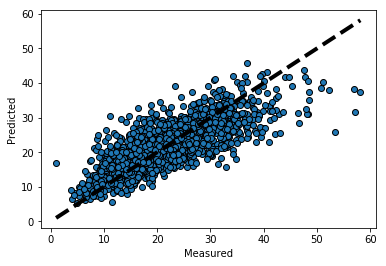

R^2: 0.6008829203268702
Root Mean Squared Error: 5.1048678799262275


In [107]:
x_dataclust=clustcarr.drop('retards',axis=1)
y_valclust=clustcarr['retards']
X_train, X_test, y_train, y_test = train_test_split(x_dataclust, y_valclust, test_size=0.20, random_state=42)
rd=RandomForestRegressor()
rd.fit(X_train,y_train)
predictionsclust=rd.predict(X_test)
print("prediction based on test set")
plotRegression(y_test,predictionsclust)
    # Compute and print R^2 and RMSE
print("R^2: {}".format(rd.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,predictionsclust))
print("Root Mean Squared Error: {}".format(rmse))
